<a href="https://colab.research.google.com/github/genealston/googlecolab/blob/main/tfdf_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet pandas
!pip install --quiet optuna
!pip install --quiet shap
!pip install --quiet gdown
!pip install --quiet tensorflow tensorflow_decision_forests
!pip install --q matplotlib
!pip install --quiet dtreeviz

import os  
import numpy as np 
import pandas as pd
import tensorflow as tf 
import math

import datetime as dt
import random
import optuna
import shap

from sklearn.utils import resample
from keras import models
from keras import layers
from tensorflow.keras import initializers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import dtreeviz

# Decision Tree with Random Forest
import tensorflow_decision_forests as tfdf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.3.0


In [ ]:
# Install fonts
!wget https://github.com/kavin808/arial.ttf/raw/master/arial.ttf
mpl.font_manager.fontManager.addfont('arial.ttf')
mpl.rc('font', family='arial')

--2023-04-15 07:26:38--  https://github.com/kavin808/arial.ttf/raw/master/arial.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavin808/arial.ttf/master/arial.ttf [following]
--2023-04-15 07:26:38--  https://raw.githubusercontent.com/kavin808/arial.ttf/master/arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367112 (359K) [application/octet-stream]
Saving to: ‘arial.ttf.2’

arial.ttf.2         100%[===================>] 358.51K  --.-KB/s    in 0.03s   

2023-04-15 07:26:38 (10.2 MB/s) - ‘arial.ttf.2’ saved [367112/367112]



In [ ]:
# Load Training and Test sets then 
!gdown 'https://drive.google.com/uc?id=1EJd9uH-AE0TAVOtn_fyzuw5l8fpyJW-j'
!gdown 'https://drive.google.com/uc?id=1z7Fe0DEuDYSnrkIyO_l-J8WCpxPmO5cO'

Downloading...
From: https://drive.google.com/uc?id=1EJd9uH-AE0TAVOtn_fyzuw5l8fpyJW-j
To: /content/crime_train.pkl
100% 721M/721M [00:03<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z7Fe0DEuDYSnrkIyO_l-J8WCpxPmO5cO
To: /content/crime_test.pkl
100% 192M/192M [00:00<00:00, 221MB/s]


In [ ]:
crime_train = pd.read_pickle('/content/crime_train.pkl') 
crime_test = pd.read_pickle('/content/crime_test.pkl') 
crime_train = crime_train.astype('int64')
crime_test = crime_test.astype('int64')

crime_train = crime_train.sample(n=50000)
crime_test = crime_test.sample(n=5000)

In [ ]:
#Get the Number of Features in our Model for Input Layer
input_length = crime_train.shape[1]-1
print("The Number of features in the training data is", input_length) 

#Calculate the number of classes for outcomes for output layer
ouput_legnth = crime_train['force_outcome'].nunique()
print("The Number of classes in our output data is", ouput_legnth)

The Number of features in the training data is 1734
The Number of classes in our output data is 4


In [ ]:
# define the target column and create TensorFlow datasets
target = 'force_outcome'
train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(crime_train, label=target, task=tfdf.keras.Task.CLASSIFICATION)
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(crime_test, label=target, task=tfdf.keras.Task.CLASSIFICATION)


In [ ]:
# do some file clean up to save RAM
#del crime_train, crime_test

In [ ]:
# instantiate the model
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# optional step - add evaluation metrics
model_rf.compile(metrics=["mse", "mape"])

# fit the model
# "sys_pipes" is optional and it enables the display of the training logs
with sys_pipes():
  model_rf.fit(x=train_tfds)

#model_rf.fit(x=train_tfds)

Use /tmp/tmpqegmblg4 as temporary training directory
Reading training dataset...


2023-04-15 07:27:40.111544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_205' with dtype int64 and shape [50000]
	 [[{{node Placeholder/_205}}]]


Training dataset read in 0:01:39.568101. Found 50000 examples.
Training model...


[INFO 23-04-15 07:40:05.0092 UTC kernel.cc:1242] Loading model from path /tmp/tmpqegmblg4/model/ with prefix a7fd5c9483bc46db
[INFO 23-04-15 07:40:09.9965 UTC decision_forest.cc:660] Model loaded with 300 root(s), 193884 node(s), and 600 input feature(s).
[INFO 23-04-15 07:40:09.9966 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 23-04-15 07:40:09.9978 UTC kernel.cc:1074] Use fast generic engine


Model trained in 0:10:51.078096
Compiling model...


2023-04-15 07:40:11.132519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_91' with dtype int64 and shape [50000]
	 [[{{node Placeholder/_91}}]]


Model compiled.


In [ ]:
model_rf.compile(metrics=["accuracy","mae","acc","mse"])
evaluation = model_rf.evaluate(test_tfds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


#print(f"MSE: {evaluation['mse']:.2f}")
#print(f"RMSE: {math.sqrt(evaluation['mse']):.2f}")
#print(f"MAPE: {evaluation['mape']:.2f}")

5/5 [==============================] - 13s 2s/step - loss: 0.0000e+00 - accuracy: 0.9844 - mae: 0.2896 - acc: 0.9844 - mse: 0.3107

loss: 0.0000
accuracy: 0.9844
mae: 0.2896
acc: 0.9844
mse: 0.3107


In [ ]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model(model_rf, tree_idx=0, max_depth=4)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_162e5eee7e27422faa4a366d16283348"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

In [ ]:
inspector = model_rf.make_inspector()
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())
print("Evaluation metrics:",inspector.evaluation())

Model type: RANDOM_FOREST
Number of trees: 300
Objective: Classification(label=__LABEL, class=None, num_classes=4)
Input features: ["arrest_indicator_binary" (1; #1), "bodycam_ind_binary" (1; #2), "category_arrest_type_Additional_SPD_Charges_(used_by_Records_Only)" (1; #3), "category_arrest_type_Arrest_-_Declined_at_Jail" (1; #4), "category_arrest_type_CBO-not_booked" (1; #5), "category_arrest_type_CSC/CDF_(Crisis_Solution_Center_/Crisis_Diversion_Facility)" (1; #6), "category_arrest_type_External_Agency_Arrest_/_SPD_Case_(used_by_Records_only)" (1; #7), "category_arrest_type_Follow_Up_Arrest-Booked" (1; #8), "category_arrest_type_Identify_and_Release-Not_Booked" (1; #9), "category_arrest_type_New_Offense_With_Arrest-Booked" (1; #10), "category_arrest_type_Order_Violation-Booked" (1; #11), "category_arrest_type_Summons_or_Citation_(used_by_Records_only)" (1; #12), "category_arrest_type_Update_Defendant_(used_by_Records_Only)" (1; #13), "category_arrest_type_Warrant_/_Detainer-Booked" (

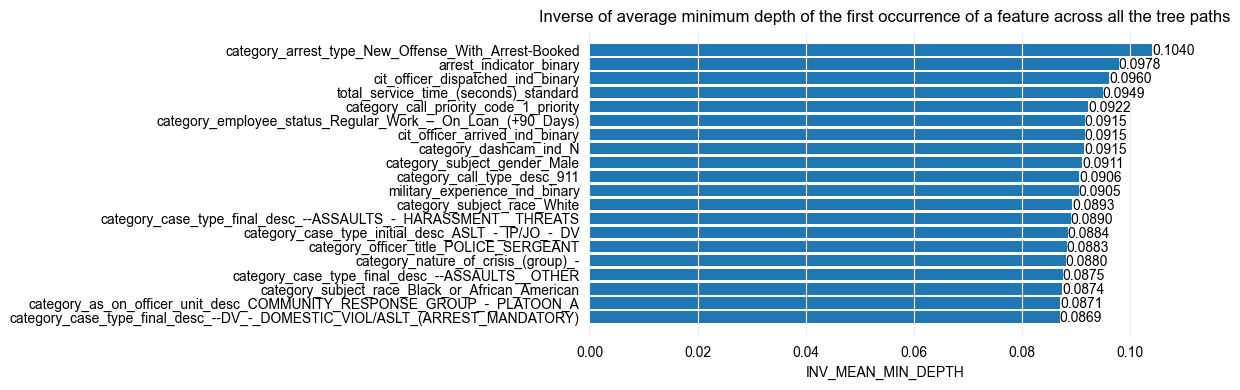

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "INV_MEAN_MIN_DEPTH"
variable_importances = inspector.variable_importances()[variable_importance_metric][:20]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")
plt.xlabel(variable_importance_metric)

plt.title("Inverse of average minimum depth of the first occurrence of a feature across all the tree paths")

# get rid of the frame and other labels
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(bottom=False, left=False)

#plt.gca().axes.get_xaxis().set_visible(False)

plt.gca().xaxis.grid(True, color='#EEEEEE')
plt.tight_layout()
plt.show()

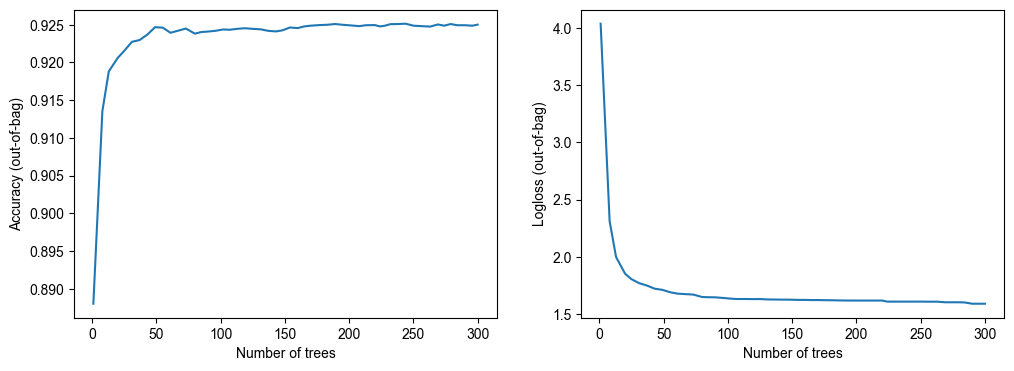

In [ ]:
# plot the RMSE during training 
logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# New Section

In [ ]:
#model_rf.save('project/crime_tfdf')

In [ ]:
crime_train_cols = crime_train.loc[:, crime_train.columns != target].columns.values.tolist()

for cr in crime_train_cols:
  print(cr)

In [ ]:
# Tell dtreeviz about training data and model
crime_features = [f.name for f in model_rf.make_inspector().features()]
viz_cmodel = dtreeviz.model(model_rf,
                           tree_index=2,
                           X_train=crime_train.loc[:, crime_train.columns != target],
                           y_train=crime_train[target],
                           feature_names=crime_features,
                           target_name=target,
                           class_names=crime_train['force_outcome'].unique())

In [ ]:
#len(list(set(crime_features).intersection(crime_train_cols)))
#len(list(set(crime_features).difference(crime_train_cols)))

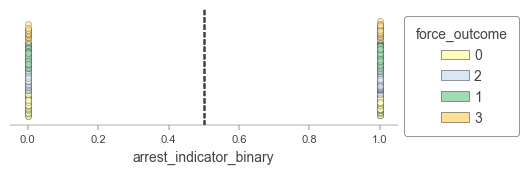

In [ ]:
viz_cmodel.ctree_feature_space(features=['arrest_indicator_binary'], show={'splits','legend'}, figsize=(5,1.5))

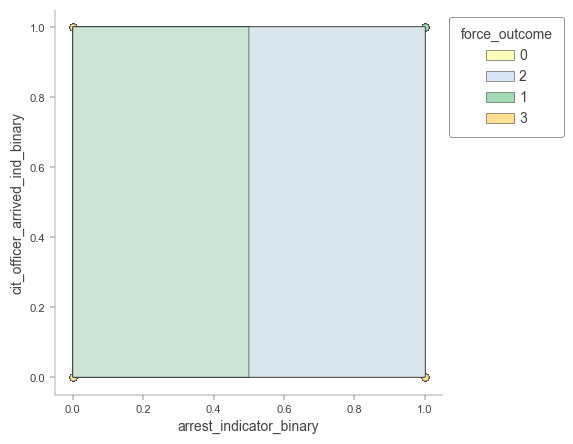

In [ ]:
viz_cmodel.ctree_feature_space(features=['arrest_indicator_binary','cit_officer_arrived_ind_binary'],
                               show={'splits','legend'}, figsize=(5,5))

In [ ]:
#x = crime_train[crime_train_cols].iloc[20]
#viz_cmodel.view(x=x, scale=.75)
#viz_cmodel.view(x=x, show_just_path=True, scale=.75)

In [ ]:
print(viz_cmodel.explain_prediction_path(x=x))

0.5 <= arrest_indicator_binary 
category_as_on_officer_squad_desc_CRG_-_SQUAD_81A < 0.5
category_beat_M3 < 0.5
category_call_type_desc_TELEPHONE_OTHER__NOT_911 < 0.5
category_case_type_final_desc_--AUTOMOBILES_-_AUTO_THEFT_&_RECOVERY < 0.5
category_case_type_final_desc_--CRISIS_COMPLAINT_-_GENERAL < 0.5
category_case_type_initial_desc_ASLT_-_IP/JO_-_DV < 0.5
category_case_type_initial_desc_PERSON_IN_BEHAVIORAL/EMOTIONAL_CRISIS < 0.5
category_officer_call_sign_1R31 < 0.5
category_officer_call_sign_A65 < 0.5
category_officer_title_POLICE_SERGEANT < 0.5
category_time_of_day_Mid_Day < 0.5
0.5 <= cit_officer_dispatched_ind_binary 
officer_cit_certified_ind_binary < 0.5
subject_juvenile_status_binary < 0.5



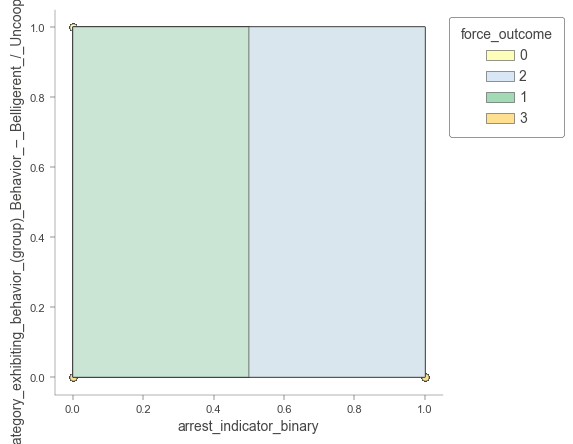

In [ ]:
#viz_cmodel.ctree_feature_space(features=['category_officer_title_POLICE_SERGEANT'], show={'splits','legend'}, figsize=(5,1.5))

viz_cmodel.ctree_feature_space(features=['arrest_indicator_binary','category_exhibiting_behavior_(group)_Behavior_–_Belligerent_/_Uncooperative'],
                               show={'splits','legend'}, figsize=(5,5))

/usr/local/lib/python3.9/dist-packages/dtreeviz/trees.py:1156: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


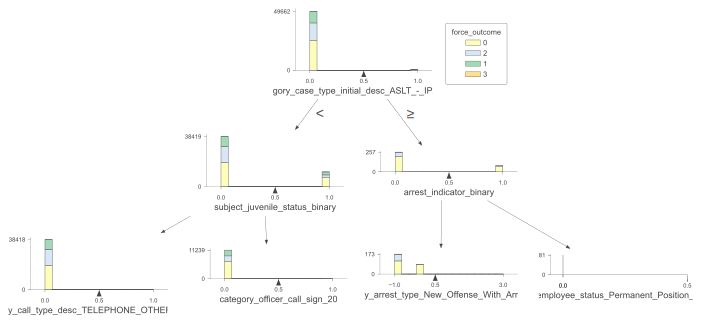

In [ ]:
#viz_cmodel.view(fancy=False)
viz_cmodel.view(depth_range_to_display=(0,2)) # root is level 0

In [ ]:
#x = crime_train[crime_train_cols].iloc[5]
#viz_cmodel.view(x=x, show_just_path=True)

In [ ]:
#flist = matplotlib.font_manager.get_font_names()
#names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]

#for names in flist:
#  print(names)

In [ ]:
val_pred = model_rf.predict(crime_train)
# Convert probability to binary answer
val_pred = val_pred == 1
val_pred = val_pred.astype('int')

conf_mtrx = confusion_matrix(crime_test[target], val_pred)
sns.heatmap(conf_mtrx, annot=True, cbar=False, fmt='g')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('actual')

ValueError: ignored